In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Загрузка и разбиение данных
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Модель MLP — многослойный перцептрон
clf = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', max_iter=500)
clf.fit(X_train, y_train)

# Отчёт о точности
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.75      0.86        12
           2       0.73      1.00      0.84         8

    accuracy                           0.90        30
   macro avg       0.91      0.92      0.90        30
weighted avg       0.93      0.90      0.90        30



D:\4_week\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Целью является сравнение различных способов векторизации текстовых данных на примере подмножества новостных текстов из набора 20 Newsgroups. Анализируется эффективность методов по скорости и числу уникальных признаков.

1. Загрузка данных. Загружаем подмножество новостных текстов по выбранным категориям

In [12]:
from sklearn.datasets import fetch_20newsgroups

categories = [
    "alt.atheism",
    "comp.graphics",
    "comp.sys.ibm.pc.hardware",
    "misc.forsale",
    "rec.autos",
    "sci.space",
    "talk.religion.misc",
]

print("Loading 20 newsgroups training data")
raw_data, _ = fetch_20newsgroups(subset="train", categories=categories, return_X_y=True)
data_size_mb = sum(len(s.encode("utf-8")) for s in raw_data) / 1e6
print(f"{len(raw_data)} documents - {data_size_mb:.3f}MB")


Loading 20 newsgroups training data
3803 documents - 6.245MB


2. Предобработка: токенизация и частоты слов. Создадим простую функцию для разбиения текста на токены и подсчета частоты слов

In [13]:
import re


def tokenize(doc):
    """Extract tokens from doc.

    This uses a simple regex that matches word characters to break strings
    into tokens. For a more principled approach, see CountVectorizer or
    TfidfVectorizer.
    """
    return (tok.lower() for tok in re.findall(r"\w+", doc))


list(tokenize("This is a simple example, isn't it?"))
from collections import defaultdict


def token_freqs(doc):
    """Extract a dict mapping tokens from doc to their occurrences."""

    freq = defaultdict(int)
    for tok in tokenize(doc):
        freq[tok] += 1
    return freq


token_freqs("That is one example, but this is another one")

defaultdict(int,
            {'that': 1,
             'is': 2,
             'one': 2,
             'example': 1,
             'but': 1,
             'this': 1,
             'another': 1})

3. Векторизация с помощью DictVectorizer. Метод превращает словарь в разреженный числовой вектор

In [14]:
from time import time

from sklearn.feature_extraction import DictVectorizer

dict_count_vectorizers = defaultdict(list)

t0 = time()
vectorizer = DictVectorizer()
vectorizer.fit_transform(token_freqs(d) for d in raw_data)
duration = time() - t0
dict_count_vectorizers["vectorizer"].append(
    vectorizer.__class__.__name__ + "\non freq dicts"
)
dict_count_vectorizers["speed"].append(data_size_mb / duration)
print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")
print(f"Found {len(vectorizer.get_feature_names_out())} unique terms")


done in 1.750 s at 3.6 MB/s
Found 47928 unique terms


4. Векторизация с помощью FeatureHasher. Метод применяет хеширование - каждому слову присваивается индекс с помощью хеш-функции

done in 0.947 s at 6.6 MB/s
Found 43873 unique tokens
done in 1.066 s at 5.9 MB/s
Found 47668 unique tokens
done in 0.909 s at 6.9 MB/s
Found 43873 unique tokens


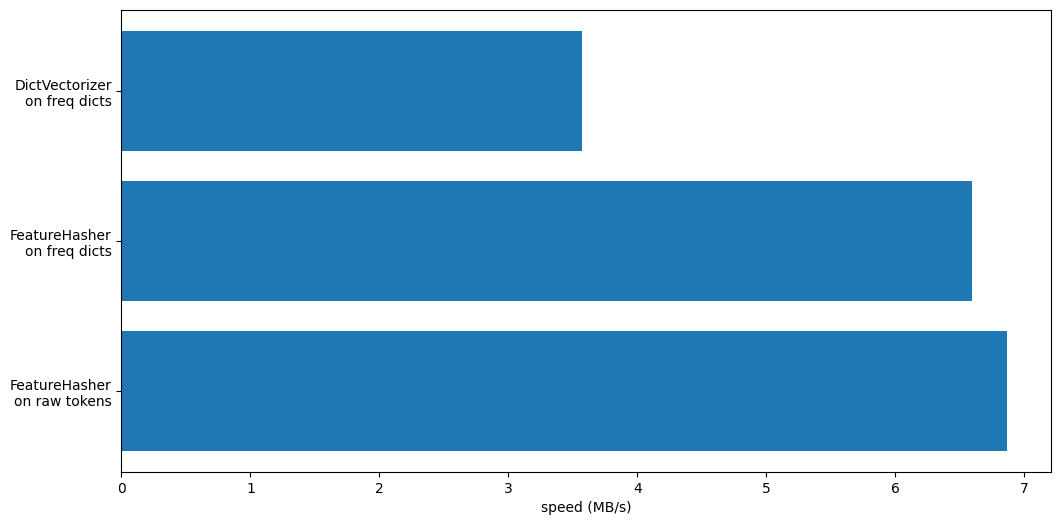

In [15]:
import numpy as np


def n_nonzero_columns(X):
    """Number of columns with at least one non-zero value in a CSR matrix.

    This is useful to count the number of features columns that are effectively
    active when using the FeatureHasher.
    """
    return len(np.unique(X.nonzero()[1]))
from sklearn.feature_extraction import FeatureHasher

t0 = time()
hasher = FeatureHasher(n_features=2**18)
X = hasher.transform(token_freqs(d) for d in raw_data)
duration = time() - t0
dict_count_vectorizers["vectorizer"].append(
    hasher.__class__.__name__ + "\non freq dicts"
)
dict_count_vectorizers["speed"].append(data_size_mb / duration)
print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")
print(f"Found {n_nonzero_columns(X)} unique tokens")
t0 = time()
hasher = FeatureHasher(n_features=2**22)
X = hasher.transform(token_freqs(d) for d in raw_data)
duration = time() - t0

print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")
print(f"Found {n_nonzero_columns(X)} unique tokens")
t0 = time()
hasher = FeatureHasher(n_features=2**18, input_type="string")
X = hasher.transform(tokenize(d) for d in raw_data)
duration = time() - t0
dict_count_vectorizers["vectorizer"].append(
    hasher.__class__.__name__ + "\non raw tokens"
)
dict_count_vectorizers["speed"].append(data_size_mb / duration)
print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")
print(f"Found {n_nonzero_columns(X)} unique tokens")
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

y_pos = np.arange(len(dict_count_vectorizers["vectorizer"]))
ax.barh(y_pos, dict_count_vectorizers["speed"], align="center")
ax.set_yticks(y_pos)
ax.set_yticklabels(dict_count_vectorizers["vectorizer"])
ax.invert_yaxis()
_ = ax.set_xlabel("speed (MB/s)")

5. Сравнение с CountVectorizer. Метод представляет из себя токенизацию и частоты слов

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

t0 = time()
vectorizer = CountVectorizer()
vectorizer.fit_transform(raw_data)
duration = time() - t0
dict_count_vectorizers["vectorizer"].append(vectorizer.__class__.__name__)
dict_count_vectorizers["speed"].append(data_size_mb / duration)
print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")
print(f"Found {len(vectorizer.get_feature_names_out())} unique terms")
from sklearn.feature_extraction.text import HashingVectorizer

t0 = time()
vectorizer = HashingVectorizer(n_features=2**18)
vectorizer.fit_transform(raw_data)
duration = time() - t0
dict_count_vectorizers["vectorizer"].append(vectorizer.__class__.__name__)
dict_count_vectorizers["speed"].append(data_size_mb / duration)
print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")

done in 1.135 s at 5.5 MB/s
Found 47885 unique terms
done in 0.868 s at 7.2 MB/s


6. HashingVectorizer. Комбинация CountVectorizer и FeatureHasher

In [17]:
from sklearn.feature_extraction.text import HashingVectorizer

t0 = time()
vectorizer = HashingVectorizer(n_features=2**18)
vectorizer.fit_transform(raw_data)
duration = time() - t0
dict_count_vectorizers["vectorizer"].append(vectorizer.__class__.__name__)
dict_count_vectorizers["speed"].append(data_size_mb / duration)
print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")


done in 1.030 s at 6.1 MB/s


7. TF-IDF Vectorizer. Преобразуем частоты слов с учетом их значимости в коллекции документов

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

t0 = time()
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(raw_data)
duration = time() - t0
dict_count_vectorizers["vectorizer"].append(vectorizer.__class__.__name__)
dict_count_vectorizers["speed"].append(data_size_mb / duration)
print(f"done in {duration:.3f} s at {data_size_mb / duration:.1f} MB/s")
print(f"Found {len(vectorizer.get_feature_names_out())} unique terms")

done in 1.334 s at 4.7 MB/s
Found 47885 unique terms


8. Визуализация. Сравним производительность (MB/s) разных подходов

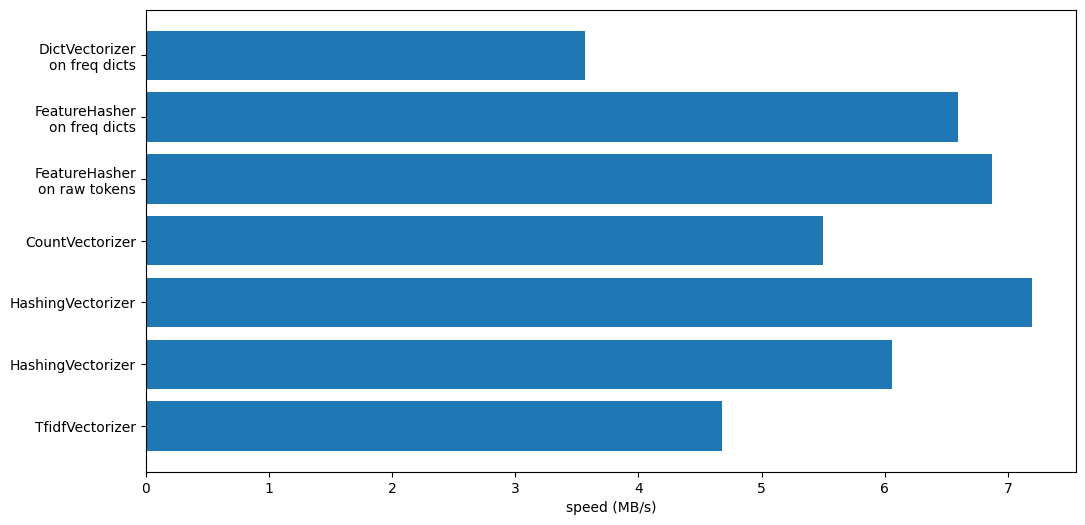

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))

y_pos = np.arange(len(dict_count_vectorizers["vectorizer"]))
ax.barh(y_pos, dict_count_vectorizers["speed"], align="center")
ax.set_yticks(y_pos)
ax.set_yticklabels(dict_count_vectorizers["vectorizer"])
ax.invert_yaxis()
_ = ax.set_xlabel("speed (MB/s)")

Задание успешно выполнено. Метод HashingVectorizer оказался самым быстрым. Он особенно быстрый на больших объемах данных и не требует хранения словаря, т.е. каждый токен сразу преобразуется в индекс по хеш-функции